In [18]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from ipywidgets import interactive, Button
from IPython.display import display








#
def planegauss(shape, w = 1/2, h = 1): # function to generate a gaussian across a 2d array, used for gaussian initial condition
    npx = np.linspace( -2, 2, shape[0] )
    npy = np.linspace( -2, 2, shape[1] )
    npxx, npyy = np.meshgrid(npx, npy)
    h = h*np.exp( -np.e * ( npxx**2 + npyy**2 ) / (w*w) )
    return (h)










#

In [25]:
#


X, Y = 0, 1 # indexing
sizex = 100 # size of grid for simulation
sizey = 100
k = 0.001 # porportion of differential equation


#initial condition constants
initcon = {}
initcon['H'] = np.ones((sizex, sizey)) # gloabal height array
initcon['H'][20:60, 20:60] = planegauss((40, 40), 2, 1) + 1 # intial condition
initcon['U'] = np.zeros((sizex, sizey)) # global x vel array
initcon['V'] = np.zeros((sizex, sizey)) # global y vel array

#globaly used height and velocity variables
H = np.array(initcon['H'])
U = np.array(initcon['U'])
V = np.array(initcon['V'])




    





#

In [20]:
#



# useful math functions

def partial(a, ax):
    partial = np.roll(a, -1, ax) - np.roll(a, 0, ax) # f(x+dx) - f(x) / dx
    return (partial)
def d_dx(a):
    d_dx = partial(a, 0)
    d_dx[0] = np.zeros(d_dx[0].shape) # first row is roll-over nonsense
    return d_dx
def d_dy(a):
    d_dy = partial(a, 1)
    d_dy[:,0] = np.zeros(d_dy[:,0].shape) # first collumn is roll-over nonsense
    return d_dy
def div(u, v):
    div = (np.roll(d_dx(u), 1, 0)+np.roll(d_dy(v), 1, 1))
    return div







#

In [21]:
#


def timestep(hi, ui, vi, dt): # work discretized differential equations
    h = hi
    u = ui
    v = vi
    
    h += -div(u, v)*dt # dh/dt = -div([u,v])
    u += -k*d_dx(h)*dt #        du/dt = -k*dh/dx
    v += -k*d_dy(h)*dt #        dv/dt = -k*dh/dy
    return h, u, v








#

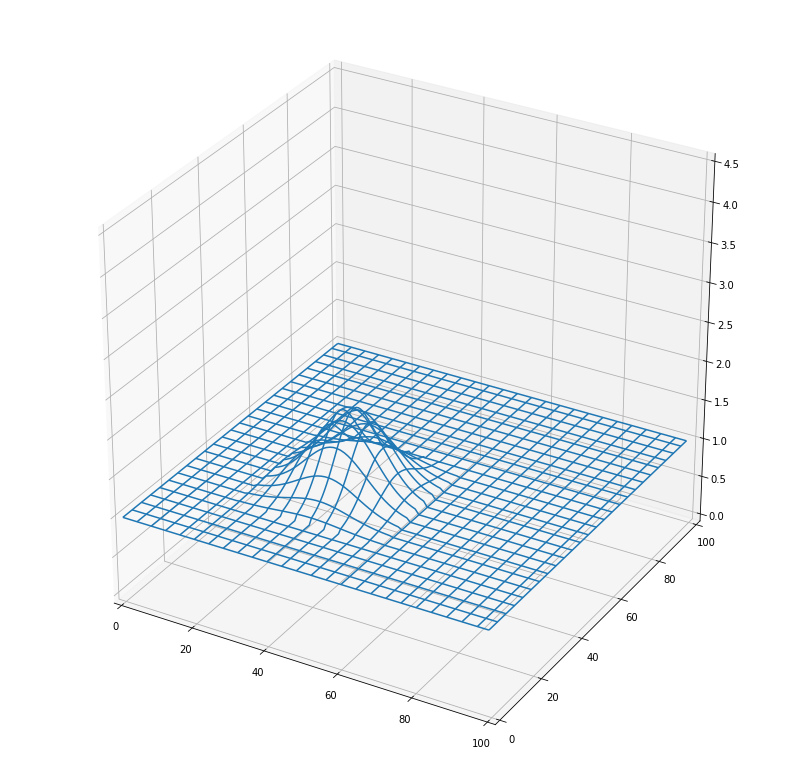

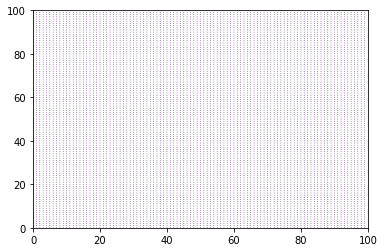

In [26]:
#




# display stuff

def dispimg(a):
    imgplot = plt.imshow(a, 'Oranges')
    plt.colorbar()
    # plt.savefig('h')

def disp3d(a, xlim, ylim, rstr = 10, cstr = 10, size = (14, 14)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(len(a))
    xx, yy = np.meshgrid(x, y)
    # Plot wireframe.
    ax.plot_wireframe(xx, yy, a, rstride=rstr, cstride=cstr)
    
    ax = plt.gca()
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(0, 4.5)
    
    plt.show()

def vect(u, v, xlim, ylim, arsize = 1):
    fig, ax = plt.subplots()
#     xx, yy = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
    m = np.hypot(u, v)
    ax.quiver(u, v, m, scale = 1/arsize)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    

    
#display initial conditions
disp3d(H, [0, 100], [0, 100], 4, 4)
vect(U, V, [0, 100], [0, 100])









#

In [28]:
#



#time


# displays resulting water height after time t
def simulate(t, dt = 1):
    # reset initial conditions
    H = np.array(initcon['H'])
    U = np.array(initcon['U'])
    V = np.array(initcon['V'])

    
    if (dt == 0):
        return False
    
    #iterate some number of times with interval size dt
    itr = 0
    while (itr < t):
        H, U, V = timestep(H, U, V, dt) # pushes H, U, V one step into the future
        itr += dt
    
    
    print('integral dxdy: ')
    print(np.sum(H))
    print('TOTAL divergence: ')
    print(np.sum(div(U, V)))
    
    # display water height
    disp3d(H, [0, 100], [0, 100], 5, 5)
    
    # display vector feild of velocity
    vect(U, V, [0, 100], [0, 100], 2)







# interact with time
controls = interactive(simulate, {'manual' : True, 'manual_name' : 'run simulation'}, # dont run until I say so
                       t = (0, 1000, 1), # time elapsed
                       dt = (0.1, 10, 0.01) # time interval
                       )
display(controls)








#

interactive(children=(IntSlider(value=500, description='t', max=1000), FloatSlider(value=1.0, description='dt'…